In [16]:
import torch
from math import pow
from NUV_test import DBG_Tester, DBG_LF_Tester
import matplotlib.pyplot as plt
from param_lin import range_nu_db, range_prec_r_db, F, H, dim_x, dim_y, m1x_0, m2x_0, T
from Linear_sysmdl import System_Model_NE
from RTS_NUV import RTS_NUV


import time
import os
import itertools

# problimatic
idx_nu, idx_r = 2, 4

# number of traj
NB = 10
# number of traj
traj_start = 0

# load data to be filtered
traj_path = 'Sim_sin_Q/Pd100/traj/'
Y_ALL = torch.load(traj_path+'Y_ALL.pt')
U_ALL = torch.load(traj_path+'U_ALL.pt')
X_ALL = torch.load(traj_path+'X_ALL.pt')


nu_db, prec_r_db = range_nu_db[idx_nu], range_prec_r_db[idx_r]

# specify the model parameter
r = pow(10, -prec_r_db/20)
q = pow(10, (nu_db-prec_r_db)/20)

Q = q*q*torch.eye(dim_x)
Q = Q.unsqueeze(2).repeat(1, 1, T)
R = r*r*torch.eye(dim_y)
R = R.unsqueeze(2).repeat(1, 1, T)        

lin_model = System_Model_NE(F, H, T, Q, R)
lin_model.init_sequence(m1x_0, m2x_0)

## problem at traj #1, time step t=373
test_input  = Y_ALL[idx_nu, idx_r, traj_start:traj_start+NB, :, :]
X_target    = X_ALL[idx_nu, idx_r, traj_start:traj_start+NB, :, :]
U_target    = U_ALL[idx_nu, idx_r, traj_start:traj_start+NB, :, :]

In [17]:
tester = DBG_Tester(lin_model)
res = tester.test(NB, test_input, X_target, q0=1.0, itr=50, win=5, forget_itr=0.0)

Unknown Q - mean MSE state:  tensor(-39.4192) [dB]
Inference Time: 6.29738712310791


In [18]:
tester = DBG_LF_Tester(lin_model)
reslf = tester.test(NB, test_input, X_target, q, 80, 0.0)

LF - sin Q - mean MSE state:  tensor(-41.7718) [dB]
Inference Time: 1.2608189582824707


In [19]:
MSE_baseline = torch.load('Sim_sin_Q/Pd100/baseline/MSE_state_rts.pt')[idx_nu, idx_r]
print('baseline: ', MSE_baseline)

baseline:  tensor(-41.5041)


In [20]:
reslf[0]

tensor([-40.4488, -43.4804, -42.0829, -41.1466, -41.5890, -42.2371, -41.8391,
        -40.5427, -43.1276, -42.2369])

# Single Traj

In [21]:
rts_uv = RTS_NUV(lin_model)
rts_uv.init_KF(m1x_0, m2x_0)
idx_traj = 4
xgt = X_target[idx_traj, :, :]
y_obs = test_input[idx_traj, :, :]
q2_raw, q2_smt, MSE_track_dB, i_stop = rts_uv.track_unknownQ_LF(y_obs, 80, q, 0.0, xgt)

print('stopped at ', i_stop, 'MSE_end', MSE_track_dB[-1])

stopped at  3 MSE_end tensor(-41.5900)


In [22]:
import torch.nn as nn
loss_func = nn.MSELoss(reduction='mean')
s_x = rts_uv.RTS.s_x
10*torch.log10(loss_func(xgt, s_x))

tensor(-41.5890)

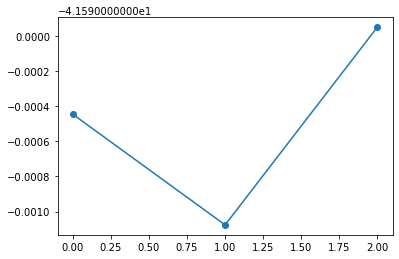

In [23]:
import matplotlib.pyplot as plt
plt.plot(MSE_track_dB[0:], 'o-')

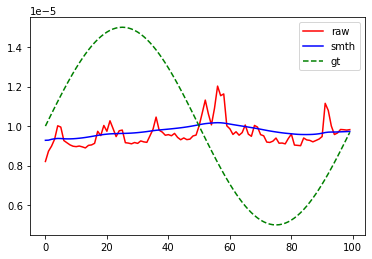

In [24]:
from gen_traj_sin_Q import periodic_Q
q2_true = periodic_Q(nu_db, prec_r_db, 100, 100)

idx_itr = i_stop-1
plt.plot(q2_raw[idx_itr, :], 'r-', label='raw')
plt.plot(q2_smt[idx_itr, :], 'b-', label='smth')
plt.plot(q2_true[0, 0, :], 'g--', label='gt')
plt.legend()
